# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [736]:
if False:
    from chxanalys.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model,
                               multi_tau_lags)

    from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

    from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis,
                                 save_g2)


    from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)
    from chxanalys.chx_compress import (combine_binary_files,
                           segment_compress_eigerdata,     create_compress_header,            
                            para_segment_compress_eigerdata,para_compress_eigerdata)

    from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc,  
)

    from chxanalys.SAXS import fit_form_factor
    from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
    from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)

    from chxanalys.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


    from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4,
                                  get_t_qrc, plot_t_qrc)

    %matplotlib notebook

In [737]:

if True:
    from chxanalys_debug.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model,
                               multi_tau_lags)

    from chxanalys_debug.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

    from chxanalys_debug.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis,
                                 save_g2)


    from chxanalys_debug.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)
    from chxanalys_debug.chx_compress_debug import (combine_binary_files,
                           segment_compress_eigerdata,     create_compress_header,            
                            para_segment_compress_eigerdata,para_compress_eigerdata)

    from chxanalys_debug.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc,  
)

    from chxanalys_debug.SAXS import fit_form_factor
    from chxanalys_debug.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
    from chxanalys_debug.chx_correlationp import (cal_g2p, auto_two_Arrayp)

    from chxanalys_debug.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


    from chxanalys_debug.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4,
                                  get_t_qrc, plot_t_qrc)

    %matplotlib notebook

In [738]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/XPCS_SAXS.py
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_compress.py

In [739]:

plt.rcParams.update({'figure.max_open_warning': 0})

In [740]:
#%reset

In [741]:
#%%javascript
#var nb = IPython.notebook;
#var kernel = IPython.notebook.kernel;
#var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
#kernel.execute(command);

In [742]:
#print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

## Make a directory for saving results

In [743]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "kyager"  #provide the username to force the results to save in that username folder
username = "commissioning"
date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/commissioning/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [1136]:
uid = '05e27b' #count : 1 ['05e27b'] (scan num: 2968) (Measurement: CoralPor 1kHz 5k frames )

uid = '1a2b7a'     #count : 1 ['1a2b7a'] (scan num: 2970) (Measurement: CoralPor 1kHz 5k frames, MBS 0.2 V x 0.05H no feedback )

uid = 'eaed19'  #count : 1 ['eaed19'] (scan num: 3929) (Measurement: coralpor 750Hz 5k ) 

uid = '701275'  #count : 1 ['701275'] (scan num: 3930) (Measurement: coralpor 750Hz 5k mbs 200x400 )

uid = 'cab6bb' #count : 1 ['cab6bb'] (scan num: 3931) (Measurement: coralpor 750Hz 5k mbs 50x200 )

uid = '9877e656' #(Measurement: coralpor 750Hz 5k mbs 100x400 )

uid = 'ce269958'#  count : 1 ['ce2699'] (scan num: 4135) (Measurement: coralpor 750Hz 5k mbs: .1x.4 )
uid = '9f73aa' #count : 1 ['9f73aa'] (scan num: 4261) (Measurement: coralpor 750Hz 2000fr )

uid = 'ca0e94'  #count : 1 ['ca0e94'] (scan num: 4263) (Measurement: coralpor 750Hz 2000fr )
uid = '2a4611' #count : 1 ['2a4611'] (scan num: 4264) (Measurement: coralpor 750Hz 2000fr )    
uid = '3001d3' #    count : 1 ['3001d3'] (scan num: 4265) (Measurement: coralpor 750Hz 2000fr )
uid = 'e17b27'   # count : 1 ['e17b27'] (scan num: 10333) (Measurement: CoralPor 750Hz 5k )

uid = 'bcb5bf'  #count : 1 ['bcb5bf'] (scan num: 10334) (Measurement: CoralPor 750Hz 2k )
uid = '06353a'  # count : 1 ['06353a'] (scan num: 10335) (Measurement: CoralPor 750Hz 2k )
uid = '4c6daa'   # count : 1 ['4c6daa'] (scan num: 10336) (Measurement: CoralPor 750Hz 2k )
uid = '41f493'   #count : 1 ['41f493'] (scan num: 10339) (Measurement: CoralPor .1ms 10k )
uid = 'fdab74'  # count : 1 ['fdab74'] (scan num: 10340) (Measurement: CoralPor .05ms 10k )

uid = '4c6daa'   # count : 1 ['4c6daa'] (scan num: 10336) (Measurement: CoralPor 750Hz 2k )

 
uid = 'fdab74'  # count : 1 ['fdab74'] (scan num: 10340) (Measurement: CoralPor .05ms 10k )


In [1137]:
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/commissioning/Results/fdab74/


# Don't Change these lines below here

In [1138]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
full_uid = sud[1]
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  10340--fdab749f-6cba-4666-8f68-a89d52694941--/XF11ID/data/2016/11/28/125709d8-1086-4848-ab34_1983


In [1139]:
imgs = load_data( uid, detector, reverse= True  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/11/28/125709d8-1086-4848-ab34_1983_master.h5


In [1140]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']  
    #md['sample']= 'SiO2 Colloidal'  #change the sample name if the md['sample'] is wrong
    print( 'The sample is %s' %md['sample'])
    
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'

The sample is CoralPor


In [1141]:
print( 'The data are: %s' %imgs )

The data are: Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 10000 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


## Overwrite Some Metadata if Wrong Input

In [1142]:
print( 'The Metadata are: \n%s' %md )

The Metadata are: 
{'beam_center_y': 816.0, 'beam_center_x': 1443.0, 'count_time': 4.9999999e-05, 'Measurement': 'CoralPor .05ms 10k', 'sample': 'CoralPor', 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32), 'y_pixel_size': 7.5000004e-05, 'incident_wavelength': 1.2848103, 'frame_time': 0.00134, 'x_pixel_size': 7.5000004e-05, 'detector_distance': 4.8899999}


In [1143]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = md['detector_distance'] *1000     # detector to sample distance (mm)
exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))
timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly
#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....

center = [  md['beam_center_x'],md['beam_center_y']  ]   #for 4M
          # center of the speckle pattern
          #assuming it was correctly entered in the eiger css screen
#center = [  md['beam_center_x'],1065-md['beam_center_y']  ]   #for 4M
#center =    [1341,1381] 
#center =    [ 507, 758] 



center=[center[1], center[0]]
print ('Beam center=', center)






The sample is CoralPor
Exposuretime=5e-05 sec, Acquisition_period=0.00134 sec
Beam center= [816.0, 1443.0]


In [1144]:
#Ldet =    4890  #in mm, in this experiments, we forget to change Ldet and kept the old 3990 mm

In [1145]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe, center=center, path= data_dir)

In [1146]:
setup_pargs

{'Ldet': 4889.9998664855957,
 'center': [816.0, 1443.0],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2848103,
 'path': '/XF11ID/analysis/2016_3/commissioning/Results/fdab74/',
 'timeperframe': 0.00134,
 'uid': 'fdab74'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [1147]:

mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Nov28_4M_SAXS_mask.npy'

<IPython.core.display.Javascript object>


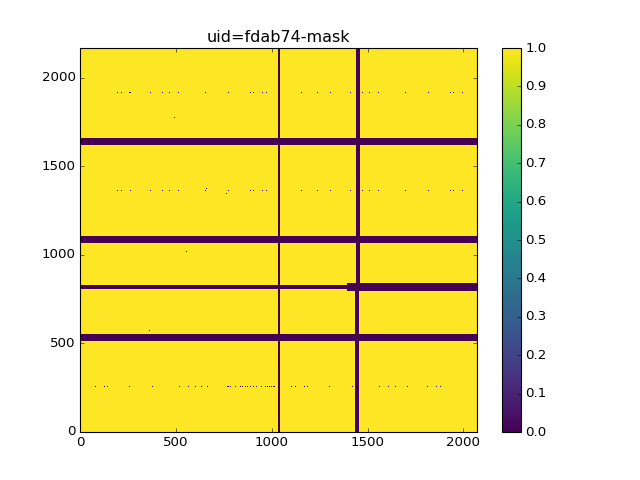

In [1148]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid=%s-mask'%uid, reverse=True )
mask_load=mask.copy()


# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [1151]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = None #NOTEBOOK_FULL_PATH
psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
md = pload_obj(data_dir + 'uid=%s-md'%uid  )

In [1152]:
imgsa = apply_mask( imgs, mask )

In [1153]:
#show_img( imgsa[0],  vmin= .01, vmax=50, logs= True, image_name= 'uid= %s'%uid) 

<IPython.core.display.Javascript object>


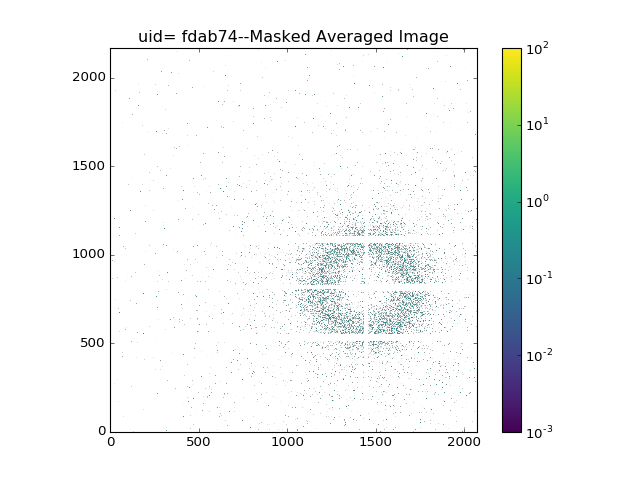

In [1154]:
avg_img =  get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = True, uid =uid)

## Determine Compress Or Not

In [1212]:
photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
compress =  photon_occ < .4  #if the photon ocupation < 0.5, do compress

print ("The non-zeros photon occupation is %s."%( photon_occ))
print("Will " + ['NOT', 'DO'][compress]  + " apply compress process.")

The non-zeros photon occupation is 0.045096740969616717.
Will DO apply compress process.


## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [1213]:
good_start = 0  #make the good_start at least 0

In [1214]:
#compress = True





In [1215]:
if False:
    if compress:
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1]
        mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                                    force_compress= False, bad_pixel_threshold= 1e14,nobytes=4,
                                            para_compress=True, num_sub= 10)    

        min_inten = 10    
        good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
        print ('The good_start frame number is: %s '%good_start)

        FD = Multifile(filename, good_start, len(imgs))
        
        #FD = Multifile(filename, 10,100)

        plot1D( y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])],
               title ='Uid= %s--imgsum'%uid, xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_fdab749f-6cba-4666-8f68-a89d52694941.cmp.
hdf5 path = /XF11ID/data/2016/11/28/125709d8-1086-4848-ab34_1983_master.h5


Get each frame intensity: 100%|██████████| 10000/10000 [00:01<00:00, 7185.50it/s]


No bad frames are involved.
The good_start frame number is: 0 


<IPython.core.display.Javascript object>


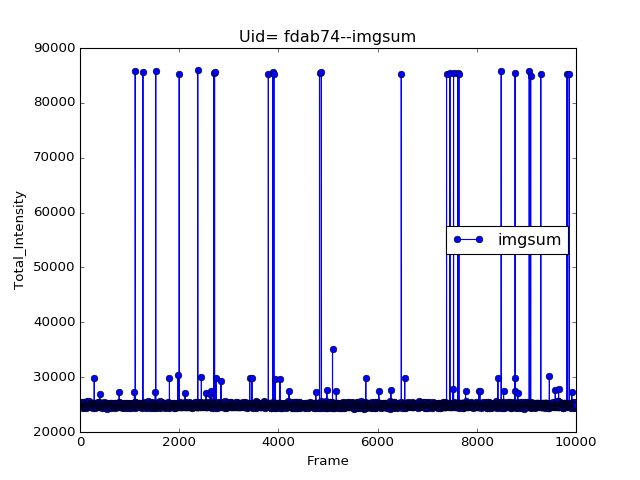

Total time: 0.12 min


In [1216]:
t0= time.time()

if True:
    if compress:
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1]
        #filename = '/XF11ID/analysis/Compressed_Data/debug' +'/uid_%s.cmp'%sud[1]
        mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(uid,  mask, md, filename, 
                                    force_compress= False, bad_pixel_threshold= 2.4e18, nobytes=4,
                                            para_compress= True, num_sub= 100, dtypes='uid', reverse=True  )    

        min_inten = 10    
        good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
        print ('The good_start frame number is: %s '%good_start)

        FD = Multifile(filename, good_start, len(imgs))
        
        #FD = Multifile(filename, good_start,500)

        plot1D( y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])],
               title ='Uid= %s--imgsum'%uid, xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
        
run_time(t0)

In [771]:
#%system ls -lh {sud[2][0]+"*"}|tail -2 ; ls -lh {filename}

In [1217]:
bad_pixel_threshold= 1.7*10**15  # 2.4*10**15  #if re-define a bad pixel threshold
bad_pixel_low_threshold= 0#1.8*10**15  #if re-define a bad pixel threshold


In [1218]:
if bad_pixel_threshold<1e14:
    mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                    force_compress=False, bad_pixel_threshold= bad_pixel_threshold, 
                bad_pixel_low_threshold= bad_pixel_low_threshold, nobytes=4)
    min_inten = 10
    good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )   
    
    print ('The good_start frame number is: %s '%good_start)


## Define a good time series by defining a good start and good end

In [1219]:
if False:
        good_start = 0  #0
        good_end =     len(imgs)
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1] 
        FD = Multifile(filename, good_start, good_end)
        avg_img= get_avg_imgc( FD,  beg= None,end=None, plot_=False )
        imgsum,bad_frame_list = get_each_frame_intensityc( FD,  bad_pixel_threshold= 1e14, plot_=False )                           


In [1220]:
if not compress:   
    #sampling = 1   #sampling should be one
    sampling = 1000  #sampling should be one    
    
    good_start = check_shutter_open( imgsa,  min_inten=5, time_edge = [0,10], plot_ = False )
    print ('The good_start frame number is: %s '%good_start)
    good_series = apply_mask( imgsa[good_start:], mask )
    avg_img =  get_avg_img( good_series, sampling = sampling, plot_ = False, uid =uid)
    imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = sampling, 
                                bad_pixel_threshold= 1e14,   plot_ = False, uid=uid)
    
    

In [1221]:
#print ('The bad frame list is: %s'% bad_frame_list)
print ('The number of bad frames is : %s '%len(bad_frame_list))
print ('The good_start frame number is: %s '%good_start)
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list

The number of bad frames is : 0 
The good_start frame number is: 0 


In [1222]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'], filename='uid=%s-imgsum'%uid, path= data_dir  )
                            

<IPython.core.display.Javascript object>


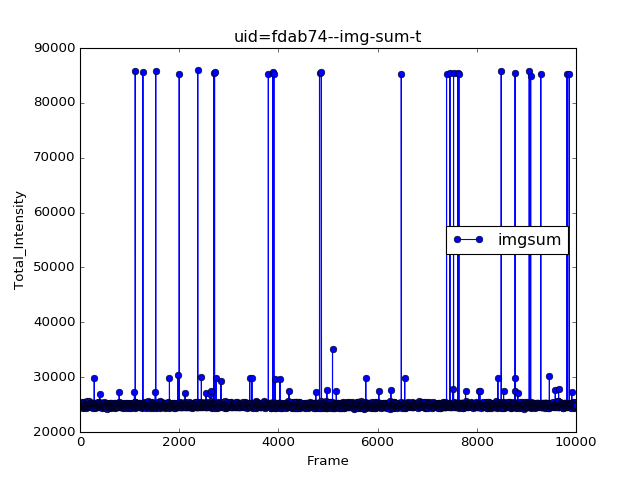

In [1223]:
plot1D( y = imgsum_y, title ='uid=%s--img-sum-t'%uid, xlabel='Frame',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

## Plot intensity average image

In [1229]:
#avg_img

<IPython.core.display.Javascript object>


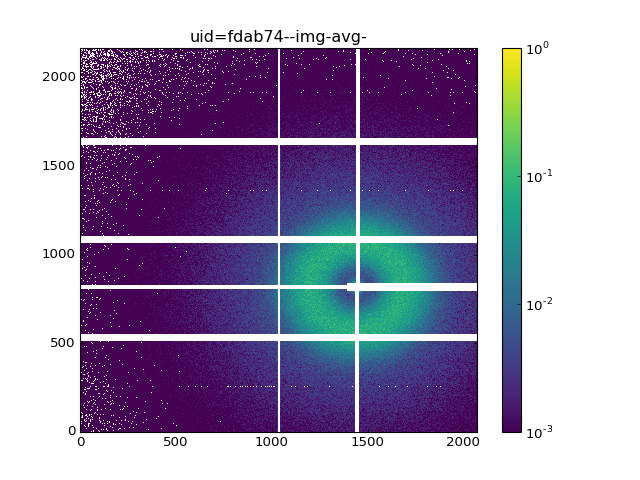

In [1228]:
#avg_img = get_avg_imgc( FD,  beg=0,end=10000,sampling = 1, plot_ = False )
show_img( avg_img,  vmin=.001, vmax=1.0, logs=True, image_name= 'uid=%s--img-avg-'%uid,
        save=True, path=data_dir) 
md['avg_img'] = avg_img

## Get circular average 
* Do plot and save q~iq


In [1230]:
#hmask = create_hot_pixel_mask( avg_img, 2**15 )
#mask = mask * hmask

<IPython.core.display.Javascript object>


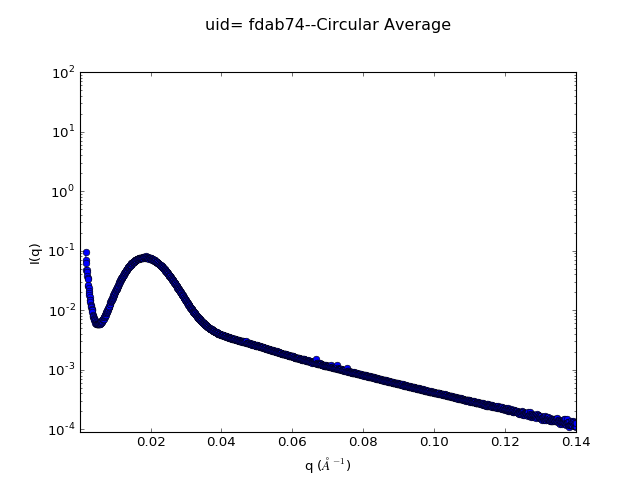

In [1231]:
hmask = create_hot_pixel_mask( avg_img, 1, center=center, center_radius=400)

qp, iq, q = get_circular_average( avg_img, mask_load * hmask, pargs=setup_pargs, nx=None,
            plot_ = True, show_pixel= False, xlim=[0.0001,.14], ylim = [0.00009, 1e2], save=True)



In [1232]:
mask = mask_load * hmask

<IPython.core.display.Javascript object>


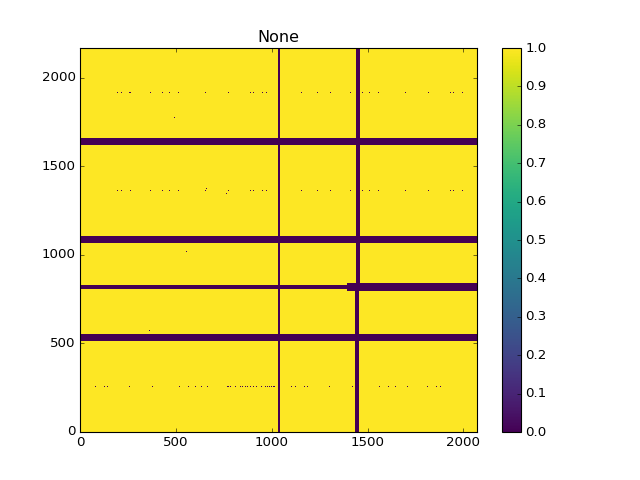

In [1233]:
show_img( mask )

# Fit Form Facotr

In [1234]:
fit_form = False

In [1235]:
if fit_form:
    form_res = fit_form_factor( q,iq,  guess_values={'radius': 2500, 'sigma':0.05, 
         'delta_rho':1E-10 },  fit_range=[0.0001, 0.015], fit_variables={'radius': T, 'sigma':T, 
         'delta_rho':T},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])
    

## Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [1250]:
uniform = True #False

### Define a non-uniform distributed rings by giving edges

In [1237]:
if not uniform:
    #width = 4  # in pixel
    width = 0.0002    
    number_rings=3
    #centers = [ 31, 50, 67, 84, 102, 119] #in pixel
    centers = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    edges = get_non_uniform_edges(  centers, width, number_rings )
    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [1267]:
if uniform:    
    
    inner_radius= 0.008  #16
    outer_radius = 0.06  #112     
    num_rings = 12
    width =  (outer_radius - inner_radius)/num_rings  #2   
    edges = None

In [1268]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                      unit='A',       pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 



In [1269]:
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]


psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters

<IPython.core.display.Javascript object>


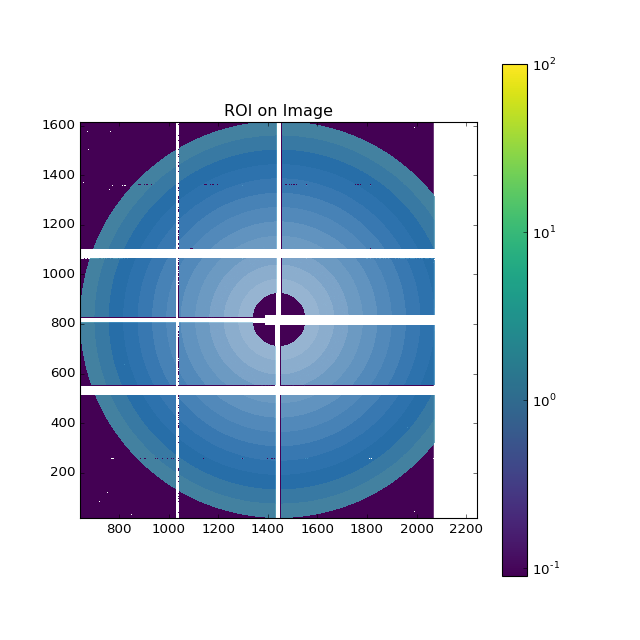

In [1270]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=800, alpha=.9,
                 save=True, path=data_dir, uid=uid, vmin=.09, vmax=1e2)

<IPython.core.display.Javascript object>


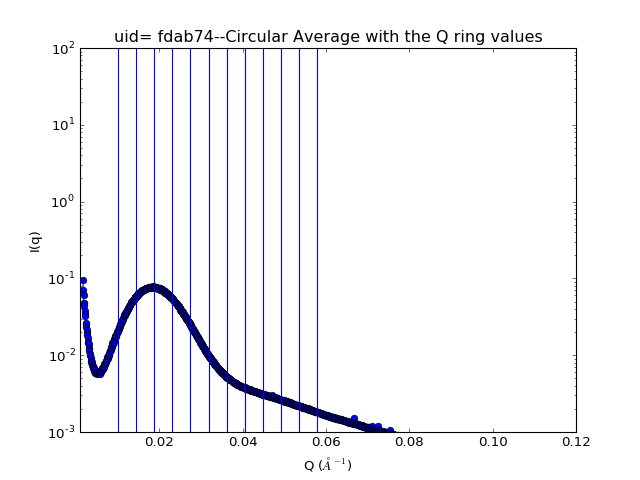

In [1359]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.001,.12],
                  ylim = [1e-3, 1e2],        save=True, path=data_dir)

## Check one ring intensity

<IPython.core.display.Javascript object>


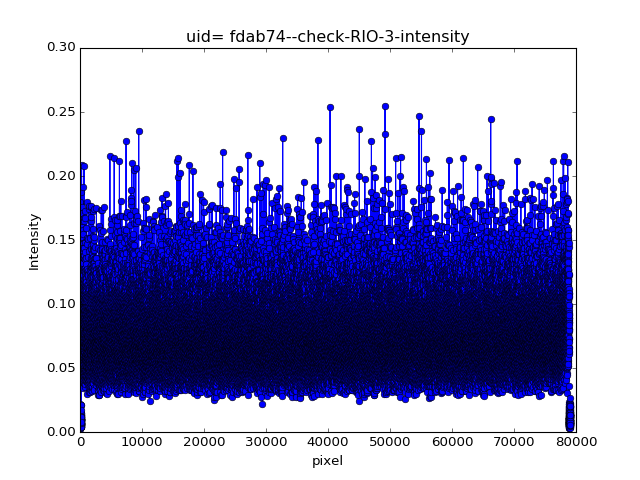

In [1274]:
roi_inten = check_ROI_intensity( avg_img, ring_mask, ring_number= 3, uid =uid, save=True, path=data_dir )

## Check beam damage
* check time~I(q)
* check mean intensity of each ring as a function of time

In [1244]:
#FD = Multifile(filename, good_start, len(imgs))

In [1275]:
if compress:
    Nimg = FD.end - FD.beg
else:
    Nimg = len(imgsa  )

In [1276]:
time_edge = create_time_slice( N= Nimg, slice_num= 6, slice_width= 1, edges = None )
time_edge =  np.array( time_edge ) + good_start

In [1277]:
compress

True

In [1209]:
#plot1D(iqst[0])

Averaging images: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


<IPython.core.display.Javascript object>


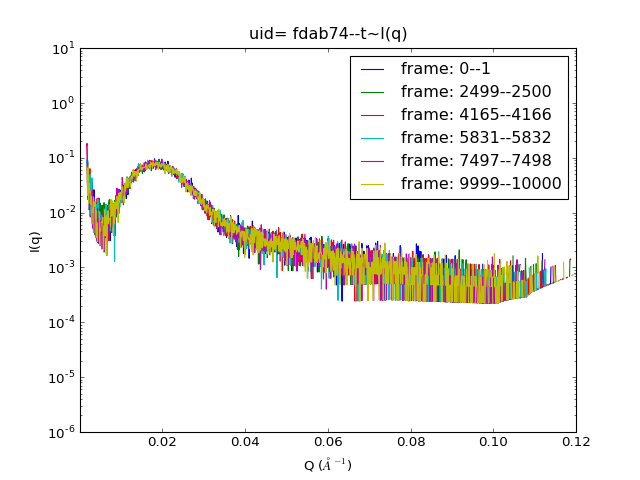

In [1278]:
if compress:
    qpt, iqst, qt = get_t_iqc( FD, time_edge, mask, pargs=setup_pargs, nx=1500, 
            plot_ = True,   xlim=[0.0001,.12], ylim = [1e-6, 10],
                              save=True, path=data_dir )
    
else:
    qpt, iqst, qt = get_t_iq( good_series, time_edge, mask*hmask, pargs=setup_pargs, nx=1500, 
                      plot_ = True,    ylim = [0.91, 1e3] ,xlim=[0.0001,.12], save=True)

## Do a waterfall analysis

In [1279]:
if False:
    if compress:
        qindex = 3 
        wat = cal_waterfallc( FD, ring_mask, qindex= qindex, save =True, path=data_dir, uid=uid)

In [1280]:
if False:
    if compress:
        plot_waterfallc( wat, qindex, aspect=None, 
                        vmax= 10, uid=uid, save =True, 
                        path=data_dir, beg= FD.beg)

Get ROI intensity of each frame: 100%|██████████| 10000/10000 [00:07<00:00, 1424.39it/s]


<IPython.core.display.Javascript object>


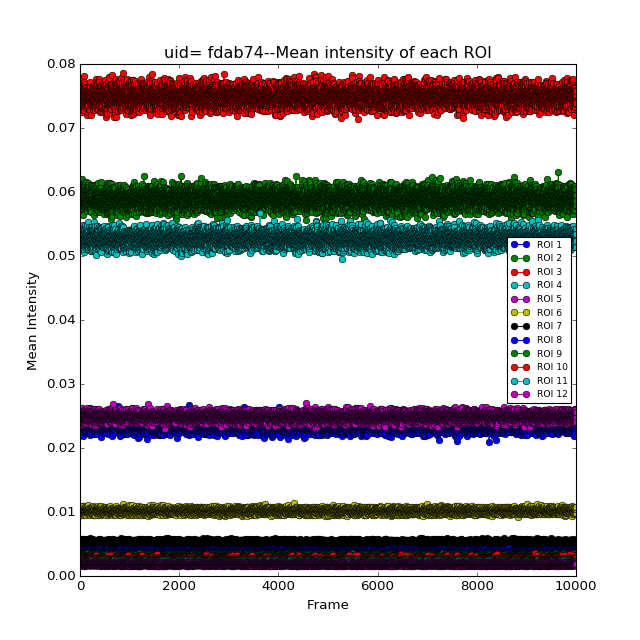

In [1281]:
if True:
    if compress:
        times, mean_int_sets = get_each_ring_mean_intensityc(FD, ring_mask,
                        timeperframe = None, plot_ = True, uid = uid, save=True, path=data_dir  )
        ring_avg = np.average( mean_int_sets, axis=0)

    else:
        mean_int_sets = get_each_ring_mean_intensity(good_series, ring_mask, sampling = sampling,
                timeperframe = md['frame_time']*sampling, 
                            plot_ = True, uid = uid, save=True, path=data_dir  )

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

### if define another good_series

In [1282]:
if False:
    good_start = 0
    good_end =  2000
    good_series = apply_mask( imgs[good_start:good_end-1], mask )
    

In [1283]:
lag_steps = None

In [1284]:
#bad_frame_list

In [1285]:
para_cal = True  #if True to use the parallel calculation


In [1286]:
norm = get_pixelist_interp_iq( qp, iq, ring_mask, center)

In [1287]:
t0 = time.time()
if compress:
    if para_cal:
        g2, lag_steps  =cal_g2p( FD,  ring_mask, bad_frame_list,good_start, num_buf = 8, 
                        imgsum= None, norm=norm )
    else:
        g2, lag_steps  =cal_g2c( FD,  ring_mask, bad_frame_list,good_start, num_buf = 8, 
                        imgsum= None, norm=norm )
else:
    bad_image_process = False
    if  len(bad_frame_list):
        bad_image_process = True
    print( bad_image_process  )

    g2, lag_steps  =cal_g2( good_series,  ring_mask, bad_image_process,
                       bad_frame_list,good_start, num_buf = 8 )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--12--
10000 frames will be processed...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/12 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 12/12 [06:23<00:00, 31.97s/it]

G2 calculation DONE!
Total time: 6.51 min


In [1288]:
lag_steps

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,   10,   12,
         14,   16,   20,   24,   28,   32,   40,   48,   56,   64,   80,
         96,  112,  128,  160,  192,  224,  256,  320,  384,  448,  512,
        640,  768,  896, 1024, 1280, 1536, 1792, 2048, 2560, 3072, 3584,
       4096, 5120, 6144, 7168])

In [1289]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir, uid=uid        )

In [1367]:
taus[:6]

array([ 0.     ,  0.00134,  0.00268,  0.00402,  0.00536,  0.0067 ])

In [1352]:
uid

'fdab74'

In [1291]:
save_saxs_g2(   g2, res_pargs )

The correlation function is saved in /XF11ID/analysis/2016_3/commissioning/Results/fdab74/ with filename as uid=fdab74--g2.csv


### Plot the one time correlation functions

<IPython.core.display.Javascript object>


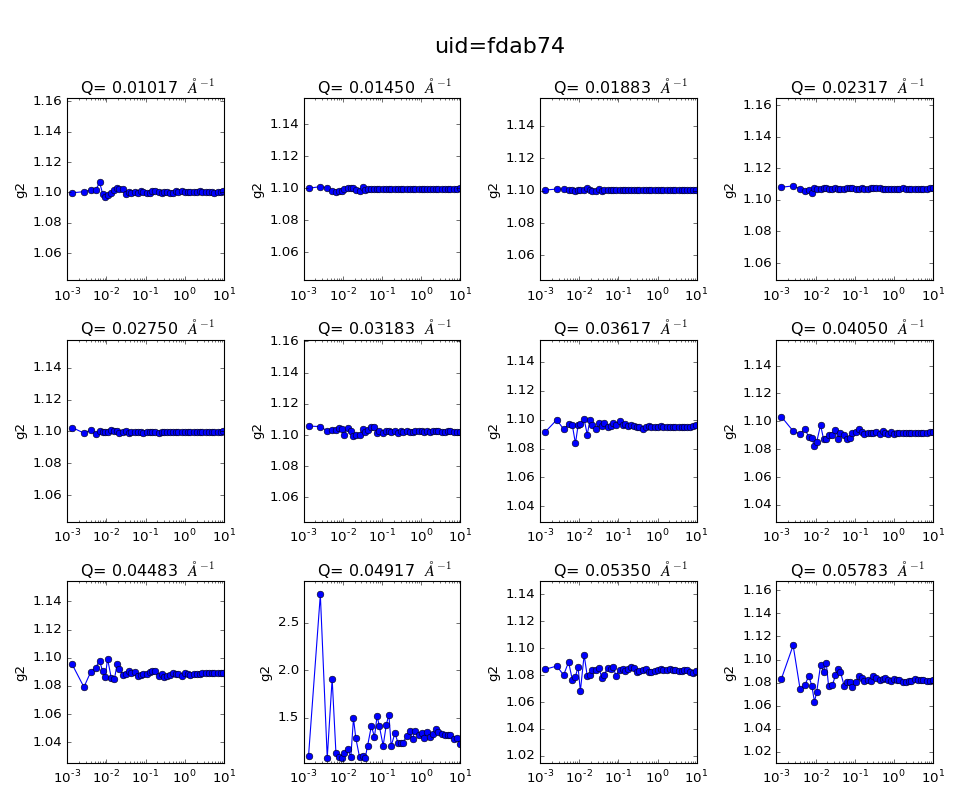

In [1351]:
plot_saxs_g2( g2, taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 

# Fit g2

In [1293]:
fit= True

<IPython.core.display.Javascript object>


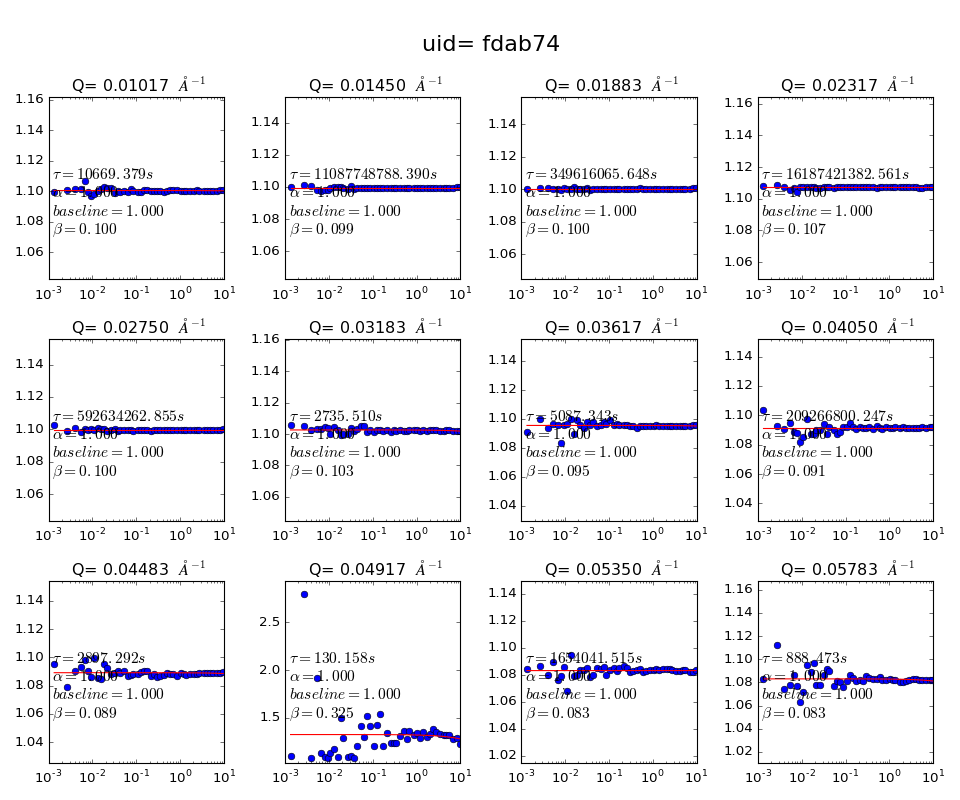

In [1294]:
if fit:    
    fit_result = fit_saxs_g2( g2, res_pargs, function = 'stretched',  vlim=[0.95, 1.05], 
        fit_variables={'baseline':False, 'beta':True, 'alpha':False,'relaxation_rate':True},
        guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01})

In [1295]:
psave_obj( fit_result, data_dir + 'uid=%s-g2-fit-para'%uid )

In [841]:
#np.arctan2(3, 1470) *180/np.pi

In [842]:
#fig,ax=plt.subplots()
#q_nums = [10,15,20]
#for q_num in q_nums:
#    plot1D(ax=ax, x=taus[1:], y= np.array( g2 )[1:,q_num ], logx=True)

The fitted diffusion coefficient D0 is:  6.624e-01   A^2S-1


<IPython.core.display.Javascript object>


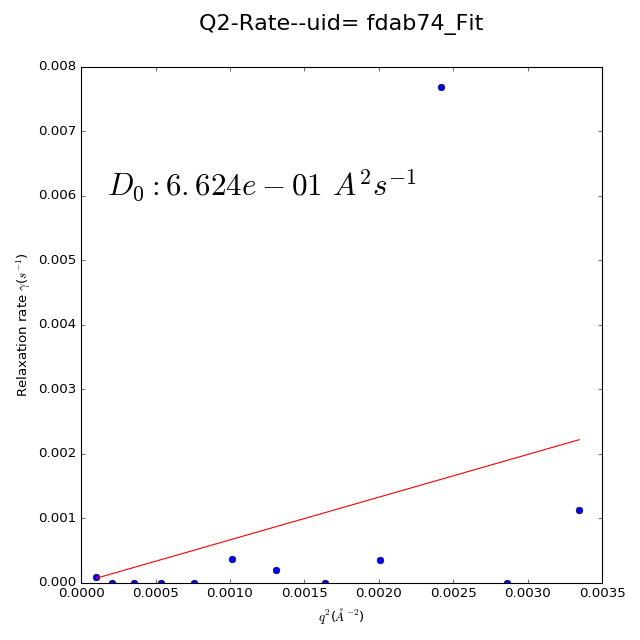

0.66242246104267943

In [1296]:
#fit_q_rate(  q_ring_center[6:12], result['rate'][6:12], power_variable=False,uid=uid, path= data_dir )
fit_q_rate(  q_ring_center[:], fit_result['rate'][:], power_variable= False,
           uid=uid, path= data_dir )

# For two-time

In [1297]:
run_two_time = False

In [1298]:
if run_two_time:
    
    if compress:
        #norm = None
        data_pixel =   Get_Pixel_Arrayc( FD, pixelist,  norm=norm ).get_data()
        if para_cal:
            g12b = auto_two_Arrayp(  data_pixel,  ring_mask, index = None   )
        else:    
            g12b = auto_two_Arrayc(  data_pixel,  ring_mask, index = None   )
            
        if lag_steps is None:
            num_bufs=8
            noframes = FD.end - FD.beg
            num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
            tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
            max_taus= lag_steps.max()
    else:
        qind, pixelist = roi.extract_label_indices(   ring_mask  )
        #good_start = 10
        #good_end = 300 #len( imgs )
        #good_series = apply_mask( imgsr[good_start:good_end-1], maskr )
        t0 = time.time()
        data_pixel =   Get_Pixel_Array( good_series , pixelist).get_data()

        run_time(t0)
        g12b = auto_two_Array( good_series,ring_mask, data_pixel = data_pixel ) 
        
        

In [1299]:
#if run_two_time:np.save(  data_dir + 'uid=%s-Two_time'%uid, g12b)

In [1300]:
if run_two_time:
    show_C12(g12b, q_ind= 2, N1=0, N2=1000, vmin=.95, vmax=1.2,
             timeperframe=timeperframe,save=True, path= data_dir, uid = uid )
    

In [1301]:
if run_two_time:

    if lag_steps is None:
        num_bufs=8
        noframes = FD.end - FD.beg
        num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
        tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
        max_taus= lag_steps.max()
        
    max_taus= lag_steps.max()    
    t0=time.time()
    g2b = get_one_time_from_two_time(g12b)[:max_taus]
    run_time(t0)
    taus2 = np.arange( g2b.shape[0])[:max_taus] *timeperframe
    res_pargs2 = dict(taus=taus2, q_ring_center=q_ring_center, path=data_dir, uid=uid        )
    save_saxs_g2(   g2b,  res_pargs2, taus=np.arange( g2b.shape[0]) *timeperframe,
                 filename='g2_from_two-time')

In [1302]:
if run_two_time:
    plot_saxs_g2( g2b, taus2,  vlim=[0.95, 1.05], res_pargs=res_pargs2)  

In [1303]:
if run_two_time:
    result2 = fit_saxs_g2( g2b, res_pargs2, function = 'simple')#, fit_range= [0, 2000 ])
    fit_q_rate(  q_ring_center, result2['rate'], uid=uid, path= data_dir )
    save_lists( [q_ring_center**2,result2['rate']], ['q2','rate'], filename= 'Q2-rate-twoT-uid=%s'%uid, path= data_dir)

In [1304]:
if run_two_time:
    plot_saxs_two_g2( g2, taus, 
                 g2b, taus2,
                 res_pargs=res_pargs, vlim=[.95, 1.05], uid= uid )

# Four Time Correlation

In [1305]:
run_four_time = False

In [1306]:
if run_four_time:
    t0=time.time()
    g4 = get_four_time_from_two_time(g12b, g2=g2b)[:max_taus]
    run_time(t0)

In [1307]:
if run_four_time:
    taus4 = np.arange( g4.shape[0])*timeperframe
    res_pargs4 = dict(taus=taus4, q_ring_center=q_ring_center, path=data_dir, uid=uid        )
    save_saxs_g2(   g4,  res_pargs4, taus=taus4,   filename='uid=%s--g4.csv' % (uid) )


In [1308]:
if run_four_time:
    plot_saxs_g4( g4, taus4,  vlim=[0.95, 1.05], logx=True, res_pargs=res_pargs4)  

# The End!

In [1309]:
create_report = True


In [1310]:
username

'commissioning'

In [1311]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

In [1319]:
if create_report:
    
    c= create_pdf_report(  data_dir, uid, pdf_out_dir,
                        filename= "XPCS_Analysis_Report_for_uid=%s-2.pdf"%uid)
    
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=1)
    c.report_meta( top=730)
    c.report_static( top=560, iq_fit =fit_form )
    c.report_ROI( top= 300)
    #Page Two: img~t/iq~t/waterfall/mean~t/g2/rate~q
    c.new_page()
    c.report_header(page=2)
    c.report_time_analysis( top= 720)
    c.report_one_time( top= 350)
    #Page Three: two-time/two g2
    
    if run_two_time:
        c.new_page()
        c.report_header(page=3)
        c.report_two_time(  top= 720 )      
        
    if run_four_time:
        c.new_page()
        c.report_header(page=4)
        c.report_four_time(  top= 720 ) 
        
    c.save_page()
    c.done()        

    


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/commissioning/Results/XPCS_Analysis_Report_for_uid=fdab74-2.pdf
****************************************


In [1320]:
c.filename

'/XF11ID/analysis/2016_3/commissioning/Results/XPCS_Analysis_Report_for_uid=fdab74-2.pdf'

In [1321]:
data_dir

'/XF11ID/analysis/2016_3/commissioning/Results/fdab74/'

## Attach the PDF report to Olog 

In [1322]:
from chxanalys.chx_olog import LogEntry,Attachment, update_olog_uid, update_olog_id

In [1323]:
#uid = '9877e656-5675-4e5b-a41b-8cc4b97a5ad0'

In [1324]:
#uid = 'ce269958-698f-46af-aaed-97dbd87dcf6e'

#uid='ce269958'

In [1325]:
uid

'fdab74'

In [1326]:
os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'

In [1327]:
c.filename

'/XF11ID/analysis/2016_3/commissioning/Results/XPCS_Analysis_Report_for_uid=fdab74-2.pdf'

In [1328]:
filename = c.filename
atch=[  Attachment(open(filename, 'rb')) ] 

update_olog_uid( uid=full_uid, text='Add XPCS Analysis PDF Report', attachments= atch )

## Attach the Analysis Notebook to Olog 

In [1329]:
#NOTEBOOK_FULL_PATH

In [1330]:
if False:
    filename = '/XF11ID/analysis'
    for s in NOTEBOOK_FULL_PATH.split("/")[4:]:  
        filename += '/'+ s


    atch=[  Attachment(open(filename, 'rb')) ] 
    update_olog_uid( uid=uid, text='Add XPCS Analysis notebook', attachments= atch )


In [1331]:
uid

'fdab74'

# 

# Speckel Visiblity

In [1865]:
def get_max_countc(FD, labeled_array ):
    """Compute the max intensity of ROIs in the compressed file (FD)

    Parameters
    ----------
    FD: Multifile class
        compressed file
    labeled_array : array
        labeled array; 0 is background.
        Each ROI is represented by a nonzero integer. It is not required that
        the ROI labels are contiguous
    index : int, list, optional
        The ROI's to use. If None, this function will extract averages for all
        ROIs

    Returns
    -------
    max_intensity : a float
    index : list
        The labels for each element of the `mean_intensity` list
    """
    
    qind, pixelist = roi.extract_label_indices(  labeled_array  ) 
    timg = np.zeros(    FD.md['ncols'] * FD.md['nrows']   , dtype=np.int32   ) 
    timg[pixelist] =   np.arange( 1, len(pixelist) + 1  ) 
    
    if labeled_array.shape != ( FD.md['ncols'],FD.md['nrows']):
        raise ValueError(
            " `image` shape (%d, %d) in FD is not equal to the labeled_array shape (%d, %d)" %( FD.md['ncols'],FD.md['nrows'], labeled_array.shape[0], labeled_array.shape[1]) )

    max_inten =0 
    for  i in tqdm(range( FD.beg, FD.end, 1  ), desc= 'Get max intensity of ROIs in all frames' ):    
        (p,v) = FD.rdrawframe(i)
        w = np.where( timg[p] )[0]
        
        max_inten = max( max_inten, np.max(v[w]) )        
    return max_inten



In [1333]:
K_mean = ring_avg #= np.average( mean_int_sets, axis=0)

In [1334]:
max_cts = get_max_countc(FD, ring_mask )

Get max intensity of ROIs in all frames: 100%|██████████| 10000/10000 [00:03<00:00, 2530.37it/s]


In [1335]:
max_cts

122

In [1940]:
qind, pixelist = roi.extract_label_indices(   ring_mask  )
noqs = len( np.unique(qind) )
nopr = np.bincount(qind, minlength=(noqs+1))[1:]

In [1941]:
time_steps = utils.geometric_series(2,   len(imgs)   ) [:-3]
time_steps

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [1942]:
num_times = len(time_steps)

In [1943]:
#show_img( imgsa[0] )

In [1944]:
bad_frame_list

array([], dtype=int64)

In [1341]:
spe_cts_all, std_dev = xsvs( (imgsa,), np.int_(ring_mask), timebin_num=2,
    number_of_img= len(imgsa), max_cts=int(max_cts+2), 
                    bad_images=bad_frame_list, threshold = 5000 )

#

/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(14, 2) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:3248: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  _data[indx] = dval
/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:3249: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  _mask[indx] = mval
/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:3117: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:3172: VisibleDeprecationWarning: using a non-integer number ins

#########Total time: 70.30 min


In [ ]:
#save data

In [1945]:
spe_cts_all.shape
std_dev.shape

(14, 12)

In [1374]:
#np.save(  data_dir + 'spe_cts_all', spe_cts_all)
#np.save(  data_dir + 'std_dev', std_dev)

In [1884]:
from lmfit import  Model
from lmfit import Minimizer, minimize, Parameters, Parameter, report_fit

from scipy import stats
from scipy.special import gamma, gammaln

from scipy.optimize import minimize

from scipy.optimize import curve_fit

In [1961]:
def nbinom_dist(bin_values, K, M):
    """
    Negative Binomial (Poisson-Gamma) distribution function
    Parameters
    ----------
    bin_values : array
        scattering bin values
    K : int
        number of photons
    M : int
        number of coherent modes
    Returns
    -------
    nbinom : array
        Negative Binomial (Poisson-Gamma) distribution function
    Notes
    -----
    The negative-binomial distribution function
    :math ::
        P(K) = \frac{\\Gamma(K + M)} {\\Gamma(K + 1) ||Gamma(M)}(\frac {M} {M + <K>})^M (\frac {<K>}{M + <K>})^K
    These implementation is based on following references
    References: text [1]_
    .. [1] L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini,
       C. Carona and A. Fluerasu , "Photon statistics and speckle visibility
       spectroscopy with partially coherent x-rays" J. Synchrotron Rad.,
       vol 21, p 1288-1295, 2014.
    """
    co_eff = np.exp(gammaln(bin_values + M) -
                    gammaln(bin_values + 1) - gammaln(M))

    nbinom = co_eff * np.power(M / (K + M), M) * np.power(K / (M + K), bin_values)
    
    return nbinom


def nbinom_dist_( x, paras):  
    para = paras.valuesdict() 
    K,M = para['K'], para['M']
    model =  nbinom_dist(x, K, M)  #get the expected photon count      
    return model


def nbinom_lnlike(paras, x, data):
    K,M = paras
    model =  nbinom_dist(x, K, M)  #get the expected photon count    
    return  -np.sum( stats.norm.logpdf(data, loc= model  ) )


def nbinom_leasq( paras, x, data):  
    K,M = paras
    model =  nbinom_dist(x, K, M)  #get the expected photon count    
    return data -  model


In [1962]:
n_mod = Model(  nbinom_dist  )

In [1999]:
g2c = g2.copy()
g2c[0] = g2[1]

<IPython.core.display.Javascript object>


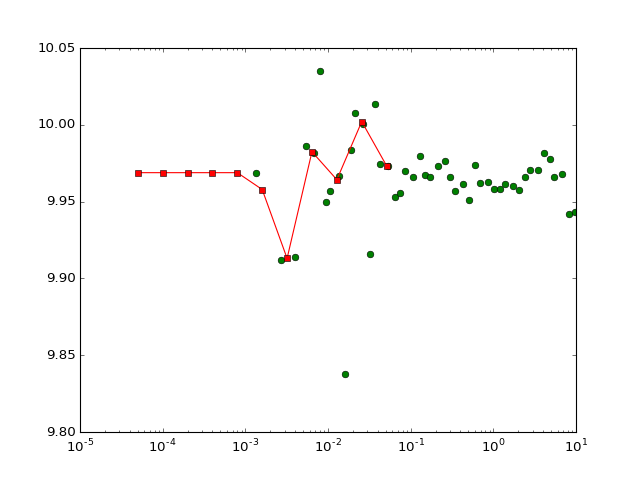

In [2017]:
fig,ax = plt.subplots()

i= 2

g2c = g2.copy()
g2c[0] = g2[1]

m0_g2 = 1/( g2c[:,i] -1 )

ax.semilogx(   taus, m0_g2, 'go')
ax.semilogx( times,  np.interp( times, taus,m0_g2), '-rs'  )



In [2242]:
i= 2
j= 8

In [2249]:
x_, x, y = bin_edges[j, i][:-1], Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i] 

In [2250]:
K_mean[i]

0.074981406202570156

In [2251]:
m0=(np.interp( times, taus, 1/( g2c[:,i] -1 )  ))[j]
m0

9.9642549967450709

In [2252]:
resultL = minimize(nbinom_lnlike,  [K_mean[i] * 2**j,10], args=(x_, y) )
print( resultL['x'][0], K_mean[i] * 2**j, resultL['x'][1], m0 ) 

19.1940192847 19.1952399879 10.0 9.96425499675


In [2253]:
result = n_mod.fit(y, bin_values=x_,  K= K_mean[i] * 2**j, M= 10 )
print( result.values['K'], K_mean[i] * 2**j, result.values['M'], m0, result.chisqr )


18.8884255427 19.1952399879 11.5157697061 9.96425499675 3.83414477738e-05


In [2254]:
x

array([  0.00000000e+00,   5.20962489e-02,   1.04192498e-01, ...,
         1.65353494e+03,   1.65358704e+03,   1.65363913e+03])

In [2255]:
x_

array([    0,     1,     2, ..., 31740, 31741, 31742])

In [2269]:
xscale = bin_edges[j, i][:-1][1]/ Knorm_bin_edges[j, i][:-1][1]

<IPython.core.display.Javascript object>


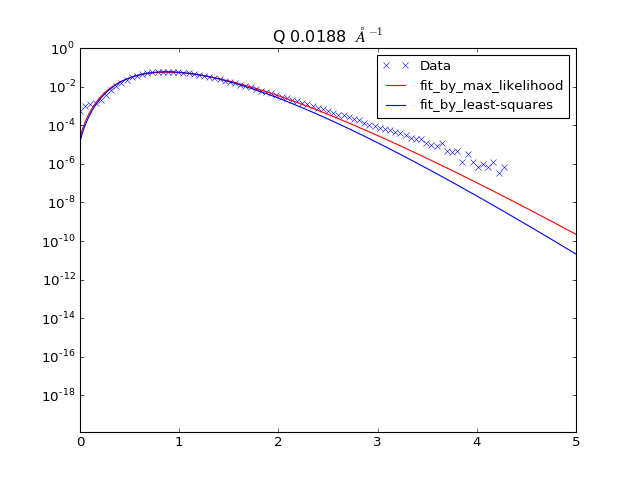

In [2274]:
fig, ax = plt.subplots()

#ax.plot( x_, y,"kx", label='Data') 

ax.plot( x, y,"bx", label='Data') 

xp_= np.linspace( 0, 150, 1000)
xp =  xp_/ xscale

#xp = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 1000     )   
#xp_ = np.linspace(0, max(bin_edges[j, i][:-1]), 1000  ) 


logs= True #False


if not logs:
    ax.plot(xp, nbinom_dist( xp_, *resultL['x']), "-r", label='fit_by_max_likelihood') 
    ax.plot(xp, nbinom_dist_( xp_, result.params), "-b",  label='fit_by_least-squares') 
else:
    ax.semilogy(xp, nbinom_dist( xp_, *resultL['x']), "-r", label='fit_by_max_likelihood') 
    ax.semilogy(xp, nbinom_dist_( xp_, result.params), "-b", label='fit_by_least-squares') 
    
    
    

#ax.semilogy
#ax.plot(x_, nbinom_dist_( x_, result2.params), 'b-')

ax.set_xlim(0, 5)
ax.set_ylim(0, 1)

ax.set_title("Q "+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
ax.legend(loc='best', fontsize = 12)

In [2209]:
report_fit( result )

[[Fit Statistics]]
    # function evals   = 13
    # data points      = 31743
    # variables        = 2
    chi-square         = 0.000
    reduced chi-square = 0.000
[[Variables]]
    M:   11.5157697 +/- 0.007148 (0.06%) (init= 10)
    K:   18.8884255 +/- 0.001734 (0.01%) (init= 19.19524)
[[Correlations]] (unreported correlations are <  0.100)
    C(M, K)                      = -0.187 


In [1946]:
bin_edges, bin_centers, Knorm_bin_edges, Knorm_bin_centers = get_bin_edges(
      len(time_steps), num_rings, K_mean, int(max_cts+2)  )

In [1947]:
time_steps

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

<IPython.core.display.Javascript object>


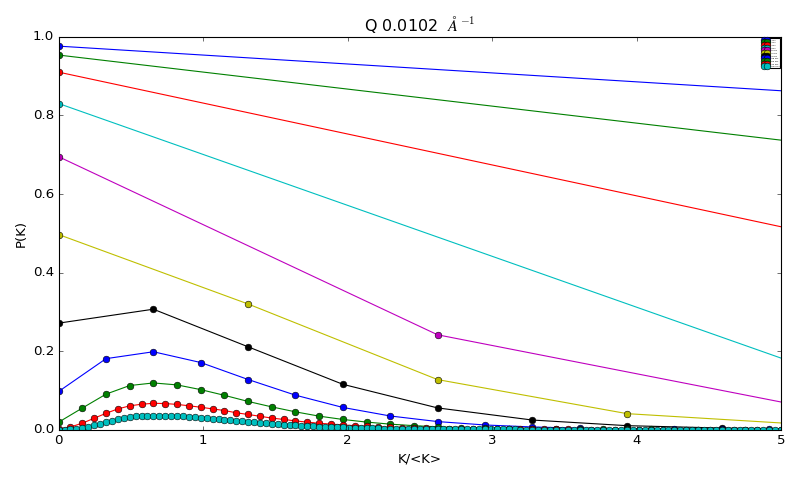

In [1917]:
if True:
    sx = int(round(np.sqrt(num_rings)) )
    if num_rings%sx == 0: 
        sy = int(num_rings/sx)
    else:
        sy=int(num_rings/sx+1)
    fig = plt.figure(figsize=(10,6))
    plt.title('uid= %s'%uid,fontsize=20, y =1.02)  
    plt.axes(frameon=False)
    plt.xticks([])
    plt.yticks([])
    for i in range(num_rings):
        for j in range(len(time_steps)):
            axes = fig.add_subplot(sx, sy, i+1 )
            axes.set_xlabel("K/<K>")
            axes.set_ylabel("P(K)")
            art, = axes.plot(Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], '-o',
                         label=str(time_steps[j])+" ms")
            axes.set_xlim(0, 5)
            axes.set_title("Q "+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
            axes.legend(loc='best', fontsize = 2)
    plt.show()
    fig.tight_layout() 

In [1349]:
from chxanalys_debug.speckle import (xsvs,get_bin_edges,gamma_dist,nbinom_dist,
                                     poisson_dist,diff_mot_con_factor)

In [1350]:
from lmfit import  Model
from scipy.interpolate import UnivariateSpline

g_mod = Model(gamma_dist, indepdent_vars=['K'])
#g_mod = Model( gamma_dist )
n_mod = Model(nbinom_dist)
p_mod = Model(poisson_dist)
dc_mod = Model(diff_mot_con_factor)

In [1922]:
num_rings = len( np.unique( ring_mask )[1:] )
num_rings

12

In [1923]:
num_times = len(time_steps)
num_times

11

In [1039]:
y = get_roi(data=y, threshold=1e-3)

In [1040]:
y

array([1, 2, 3, 4, 5])

In [1041]:
def get_roi(data, threshold=1e-3):
    roi = np.where(data>threshold)
    if len(roi[0]) > len(data)-2:
        roi = (np.array(roi[0][:-2]),)                    
    elif len(roi[0]) < 2:
        roi = np.where(data>=0)
    return roi[0]

In [1928]:
#spe_cts_all.shape

<IPython.core.display.Javascript object>


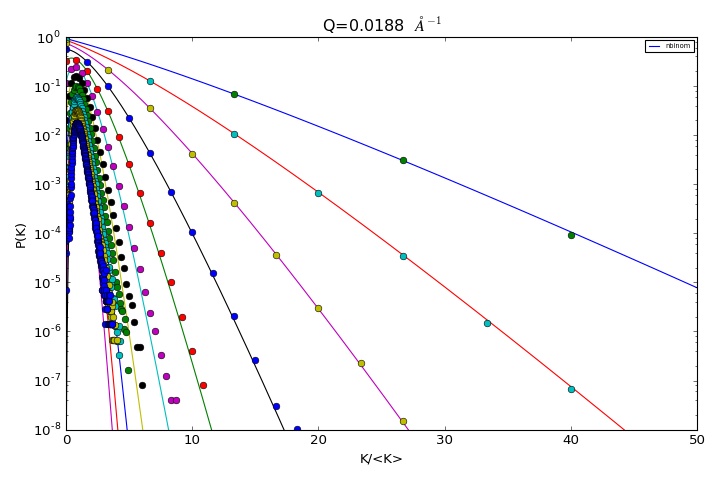

In [2284]:
M_val = {}
K_val = {}

ML_val = {}
KL_val = {}
#num_rings = 1


    
fig = plt.figure(figsize=(9, 6))
plt.title('uid= %s'%uid+" Fitting with Negative Binomial Function", fontsize=20, y=1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

#num_times = 1
for i in range(2,3):
    M_val[i]=[]
    ML_val[i]=[]
    K_val[i]=[]
    KL_val[i]=[]
    
    for j in range(   num_times  ):        
        x_, x, y = bin_edges[j, i][:-1], Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i]        
       
        mi_g2 = 1/( g2c[:,i] -1 )        
        m0=(np.interp( times, taus,  mi_g2  ))[j]
        
        result_n = n_mod.fit( y,
                             bin_values=x_,
                             K= K_mean[i] * 2**j, M= m0
                             )
        
        resultL = minimize(nbinom_lnlike,  [K_mean[i] * 2**j, m0], args=(x_, y) )

        
        M_val[i].append(result_n.best_values['M'])
        ML_val[i].append(  resultL['x'][1]   )
        
        K_val[i].append(result_n.best_values['K'])
        KL_val[i].append(    resultL['x'][0] )
        
        axes = fig.add_subplot(111 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        
        #  Using the best K and M values interpolate and get more values for fitting curve
        
        xscale = bin_edges[j, i][:-1][1]/ Knorm_bin_edges[j, i][:-1][1]
        fitx = np.linspace(0, 150, 5000     )
        fitx_ = fitx / xscale 
        
        
        fity = nbinom_dist( fitx, K_val[i][j], M_val[i][j] ) # M and K are fitted best values
        fitL = nbinom_dist( fitx, KL_val[i][j], ML_val[i][j] ) # M and K are fitted best values
        
        fity2 = nbinom_dist( fitx, K_val[i][j], 
                    (np.interp( times, taus, 1/( g2[:,1] -1 )  ))[j] )  # M and K are fitted best values

        
        if j == 0:
            art, = axes.semilogy( fitx_,fity, '-',  label="nbinom")
            #art, = axes.plot( fitx,fitL, '-',  label="nbinom")
        else:
            art, = axes.plot( fitx_,fity, '-')
            #art, = axes.plot( fitx,fitL, '-')
                    
        if i==0:    
            art, = axes.plot(x, y, 'o',
                     label=str(time_steps[j])+" ms")
        else:
            art, = axes.plot( x, y, 'o',
                     )
        
        axes.set_xlim(0, 50)
        axes.set_ylim(1e-8, 1)
        
        # Annotate the best K and M values on the plot
        #axes.annotate(r'K='+'%.3f'%( K_val[i][j]) +','+r'M='+'%.3f'%(M_val[i][j]),
        
        if False:
            axes.annotate('from NB fit',
                      xy=(0.95, 0.6),
                      xycoords='axes fraction', fontsize=10,color='k',
                      horizontalalignment='right', verticalalignment='bottom')  
        
            axes.annotate(r'M='+'%.3f'%(M_val[i][j]),
                      xy=(0.95, 0.55-j*0.05),
                      xycoords='axes fraction', fontsize=10,color='k',
                      horizontalalignment='right', verticalalignment='bottom')

        
            axes.annotate('from g2 res',
                      xy=(.8, 0.6),
                      xycoords='axes fraction', fontsize=10,color='r',
                      horizontalalignment='right', verticalalignment='bottom') 
        
            axes.annotate(r'M='+'%.3f'%(m0),
                      xy=(.8, 0.55-j*0.05),
                      xycoords='axes fraction', fontsize=10,color='r',
                      horizontalalignment='right', verticalalignment='bottom')        
        
        
        axes.set_title("Q="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend(loc='best', fontsize = 6)
plt.show()
fig.tight_layout() 

In [2113]:
g2c = g2.copy()
g2c[0] = g2[1]



<IPython.core.display.Javascript object>


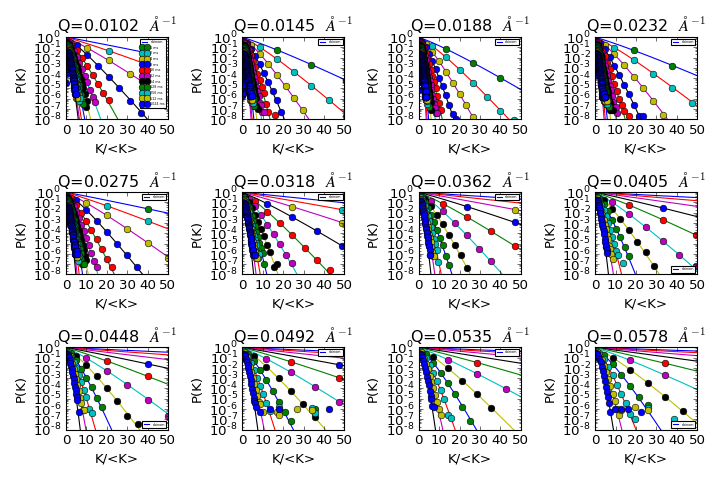

In [2286]:


M_val = {}
K_val = {}

ML_val = {}
KL_val = {}
#num_rings = 1


sx = int(round(np.sqrt(num_rings)))
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
fig = plt.figure(figsize=(9, 6))
plt.title('uid= %s'%uid+" Fitting with Negative Binomial Function", fontsize=20, y=1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

#num_times = 1
for i in range(num_rings):
    M_val[i]=[]
    ML_val[i]=[]
    K_val[i]=[]
    KL_val[i]=[]
    
    for j in range(   num_times  ):        
        x_, x, y = bin_edges[j, i][:-1], Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i]        
        # find the best values for K and M from fitting
        
        #w=get_roi(data=y, threshold=1e-8)
        #y = y[w]
        #x_= x_[w]
        #x=x[w]
        
        mi_g2 = 1/( g2c[:,i] -1 )        
        m0=(np.interp( times, taus,  mi_g2  ))[j]
        
        result_n = n_mod.fit( y,
                             bin_values=x_,
                             K= K_mean[i] * 2**j, M= m0
                             )
        
        resultL = minimize(nbinom_lnlike,  [K_mean[i] * 2**j, m0], args=(x_, y) )
        
        #m0=(np.interp( times, taus, 1/( g2[:,1] -1 )  ))[j]
        #M_val[i].append(m0)
        
        M_val[i].append(result_n.best_values['M'])
        ML_val[i].append(  resultL['x'][1]   )
        
        K_val[i].append(result_n.best_values['K'])
        KL_val[i].append(    resultL['x'][0] )
        
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        
        #  Using the best K and M values interpolate and get more values for fitting curve
        
        xscale = bin_edges[j, i][:-1][1]/ Knorm_bin_edges[j, i][:-1][1]
        
        
        fitx = np.linspace(0, 150, 5000     )
        fitx_ = fitx / xscale 
        
        fity = nbinom_dist( fitx, K_val[i][j], M_val[i][j] ) # M and K are fitted best values
        fitL = nbinom_dist( fitx, KL_val[i][j], ML_val[i][j] ) # M and K are fitted best values
        
        fity2 = nbinom_dist( fitx, K_val[i][j], 
                    (np.interp( times, taus, 1/( g2[:,1] -1 )  ))[j] )  # M and K are fitted best values

        
        if j == 0:
            art, = axes.plot( fitx_,fity, '-',  label="nbinom")
            #art, = axes.plot( fitx,fitL, '-',  label="nbinom")
        else:
            art, = axes.plot( fitx_,fity, '-')
            #art, = axes.plot( fitx,fitL, '-')
                    
        if i==0:    
            art, = axes.semilogy(x, y, 'o',
                     label=str(time_steps[j])+" ms")
        else:
            art, = axes.semilogy( x, y, 'o',
                     )
        
        axes.set_xlim(0, 50)
        axes.set_ylim(1e-8, 1)
        
        # Annotate the best K and M values on the plot
        #axes.annotate(r'K='+'%.3f'%( K_val[i][j]) +','+r'M='+'%.3f'%(M_val[i][j]),
        
        if False:
            axes.annotate('from NB fit',
                      xy=(0.95, 0.6),
                      xycoords='axes fraction', fontsize=10,color='k',
                      horizontalalignment='right', verticalalignment='bottom')  
        
            axes.annotate(r'M='+'%.3f'%(M_val[i][j]),
                      xy=(0.95, 0.55-j*0.05),
                      xycoords='axes fraction', fontsize=10,color='k',
                      horizontalalignment='right', verticalalignment='bottom')

        
            axes.annotate('from g2 res',
                      xy=(.8, 0.6),
                      xycoords='axes fraction', fontsize=10,color='r',
                      horizontalalignment='right', verticalalignment='bottom') 
        
            axes.annotate(r'M='+'%.3f'%(m0),
                      xy=(.8, 0.55-j*0.05),
                      xycoords='axes fraction', fontsize=10,color='r',
                      horizontalalignment='right', verticalalignment='bottom')        
        
        
        axes.set_title("Q="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend(loc='best', fontsize = 3)
plt.show()
fig.tight_layout() 

In [2226]:
ML_val[2][8]

9.9642549967450709

In [2227]:
M_val[2][8]

11.515770510680875

<IPython.core.display.Javascript object>


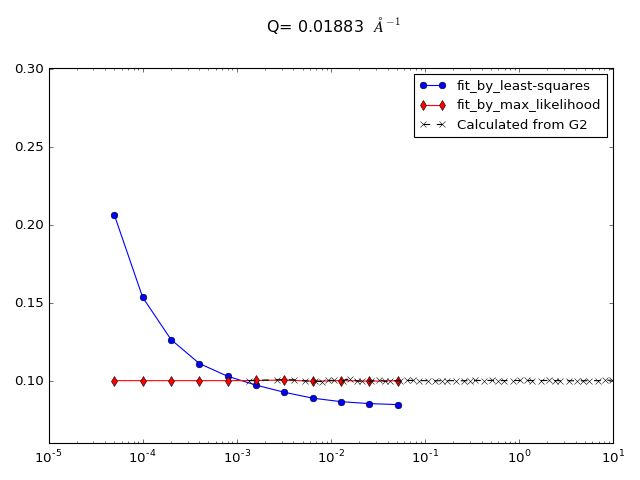

In [2147]:
fig = plt.figure()
plt.title('uid= %s'%uid + "Contrast Factor for Each Q Rings", fontsize=14, y =1.08)  
#plt.axis('off')

sn = 2
ax = fig.add_subplot(1,1,1 ) 
y= contrast_factor[sn, :]   
yL= contrast_factorL[sn, :]  
g = g2c[:,sn] -1 
#ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
ax.semilogx(times, y, "-bo",  label='fit_by_least-squares') 
ax.semilogx(times, yL, "-rd", label='fit_by_max_likelihood') 
ax.semilogx(taus, g, "--kx", label='Calculated from G2') 
            

ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$') 

ym = np.mean( g )
ax.set_ylim([ym*.6, ym *3])

ax.legend(loc='best', fontsize = 12)              
 
fig.tight_layout() 

<IPython.core.display.Javascript object>


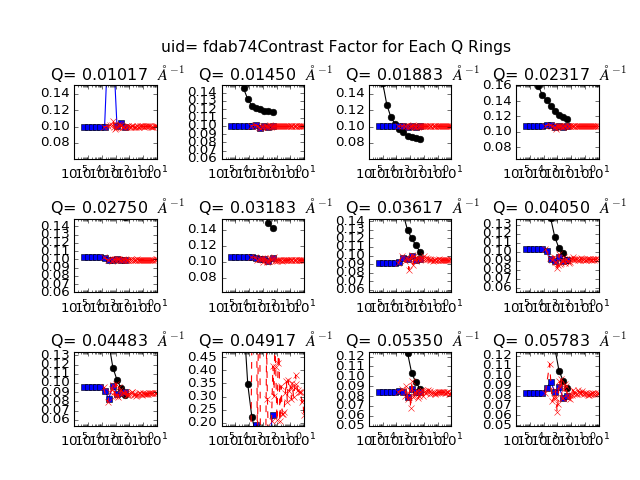

In [2137]:
contrast_factor = np.zeros((num_rings, num_times))
contrast_factorL = np.zeros((num_rings, num_times))
for i in range(num_rings):    
    for j in range(num_times):
        contrast_factor[i, j] =  1/M_val[i][j]
        contrast_factorL[i, j] =  1/ML_val[i][j]
        
        

sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid + "Contrast Factor for Each Q Rings", fontsize=14, y =1.08)  
plt.axis('off')
for sn in range(num_rings):
    ax = fig.add_subplot(sx, sy, sn+1 ) 
    y= contrast_factor[sn, :]   
    yL= contrast_factorL[sn, :]  
    g = g2c[:,sn] -1 
    #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.semilogx(times, y, "-ko", 
                label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$') 
    
    ax.semilogx(times, yL, "-bs", 
                label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')  
    
    ax.semilogx(taus, g, "--rx", 
                label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')  
    
    ym = np.mean( g )
    ax.set_ylim([ym*.6, ym *1.5])   
              
 
fig.tight_layout() 

In [1045]:
result_n.chisqr

0.060200119117237313

In [1046]:
print( result_n.fit_report() )

[[Model]]
    Model(nbinom_dist2)
[[Fit Statistics]]
    # function evals   = 16
    # data points      = 18
    # variables        = 2
    chi-square         = 0.060
    reduced chi-square = 0.004
[[Variables]]
    M:   12.5014897 +/- 0.361062 (2.89%) (init= 10.60433)
    K:   5.80233828 +/- 0.014191 (0.24%) (init= 5.823403)
[[Correlations]] (unreported correlations are <  0.100)
    C(M, K)                      =  0.405 


In [1103]:
K_mean_fit = np.array( [K_val[i][0] for i in range(num_rings)] )
K_mean_fit

array([ 1.47956796,  2.05093601,  1.57156641,  0.78368984,  0.32689245,
        0.16372116,  0.11059334,  0.08957307,  0.0768694 ,  0.06483667,
        0.05449304,  0.04550385])

In [1104]:
K_mean

array([ 1.49733276,  2.07939608,  1.59152449,  0.79207229,  0.33099809,
        0.16464034,  0.11088771,  0.0896555 ,  0.07693307,  0.06485095,
        0.05452385,  0.04549534])

In [1105]:
K_mean_fit - K_mean

array([ -1.77647964e-02,  -2.84600695e-02,  -1.99580749e-02,
        -8.38244770e-03,  -4.10564022e-03,  -9.19176712e-04,
        -2.94372785e-04,  -8.24272574e-05,  -6.36712894e-05,
        -1.42842017e-05,  -3.08074886e-05,   8.50917179e-06])

In [1106]:
#roi_fit = get_roi(data=spe_cts_all[j, i], threshold=1e-3)

In [1107]:
#roi_fit

In [1108]:
contrast_factor = np.zeros((num_rings, num_times))

for i in range(num_rings):
    for j in range(num_times):
        contrast_factor[i, j] =  1/M_val[i][j]

In [1109]:
contrast_factor[0, :]

array([ 0.11159475,  0.10004365,  0.09662961,  0.09501501,  0.09397031,
        0.09303843,  0.09217638,  0.09155334])

In [1949]:
times = np.array( time_steps ) * exposuretime

In [1111]:
exposuretime

0.00133

<IPython.core.display.Javascript object>


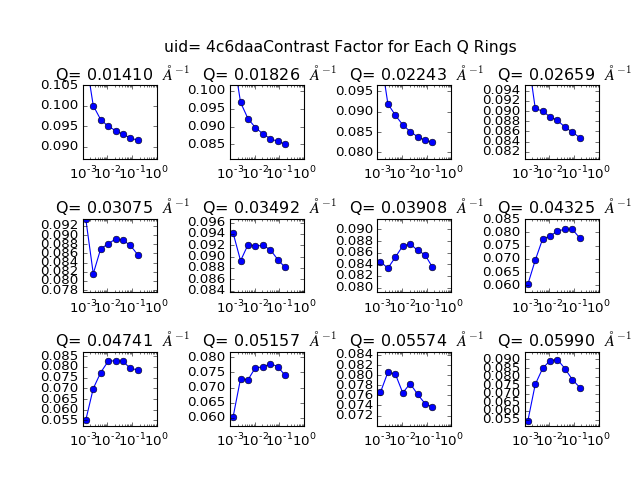

In [1114]:
 
sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid + "Contrast Factor for Each Q Rings", fontsize=14, y =1.08)  
plt.axis('off')
for sn in range(num_rings):
    ax = fig.add_subplot(sx, sy, sn+1 ) 
    y= contrast_factor[sn, :]   
    #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.semilogx(times, y, "-o", 
                label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$') 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
              
 
fig.tight_layout() 

In [1097]:
contrast_factor.shape

(12, 8)

In [1098]:
g2.shape

(39, 12)

<IPython.core.display.Javascript object>


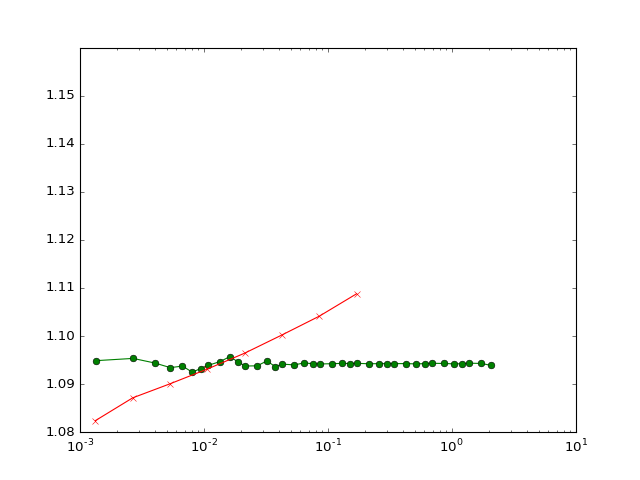

(1.08, 1.16)

In [1099]:
i= 1

fig,ax =plt.subplots()
ax.semilogx( taus, g2[:,i], '-go', label='g2' )
ax.semilogx( times, 1+ contrast_factor[i,:], '-rx', label='contrast' )
ax.set_ylim([1.08, 1.16] )
#plot1D(  x= times, y= contrast_factor[0,:], logx=True ,ax=ax, ylim=[1.08, 1.11] )
